In [5]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.io import ascii
from astropy import constants as const

# some kind of reading in will occur here
# for now i think i might just use some wikipedia stats...
# or wait until shane gets back to me with his data for me to read from

#amcvn_binaryDATfile.dat
filename = open('binary.dat','r')
dummy = pd.read_csv('binary.dat', delim_whitespace=False, comment='#', header=None)
print(dummy)

# the new commands were being super finicky so im doing this college python course style
# super not optomized! but i can get to that later once i know stuff works

datalist = []
amcvn = filename.readlines()
amcvn
for item in amcvn:
    equals = item.index('=')
    datalist.append(item[equals+2:-1])
datalist

                               0
0   basename  = naomiTest_1orbit
1             a (AU)    = 0.0010
2               ecc       = 0.75
3                inc (deg) = 0.0
4                m1 (msun) = 0.5
5                m2 (msun) = 0.5
6           R (pc)    = 1.000000
7                thN (deg) = 0.0
8                thP (deg) = 0.0
9                phi (deg) = 0.0
10            th1 (deg) = 0.0000
11  tsim (yr) = 3.16875357869e-5
12              Npts      = 1024
13                 fftFlag   = 1


['naomiTest_1orbit',
 '0.0010',
 '0.75',
 '0.0',
 '0.5',
 '0.5',
 '1.000000',
 '0.0',
 '0.0',
 '0.0',
 '0.0000',
 '3.16875357869e-5',
 '1024',
 '1']

In [6]:
# initial condition

tsim = 1.5 #11000 #datalist[11] #= 6.16 * (10**-5)
#tsim = tsim * (3.15*(10**7))
print(tsim)

#masses, switching to SI units aka kg
mass1 = eval(datalist[4])
mass2 = eval(datalist[5])
solarmass = 1.989 * (10**30)
mass1 = mass1 * solarmass
mass2 = mass2 * solarmass
print(mass1)
print(mass2)

#semi-major axis
smajaxis = eval(datalist[1])
aumeter = 1.496 * (10**11)
smajaxis = smajaxis * aumeter
print(smajaxis)

#eccentricity 
ecc = eval(datalist[2])
print(ecc)

#orbital period
g = const.G.value # already in SI
print(g)
initnumer = 4 * (np.pi**2) * (smajaxis**3)
initdenom = (mass1 + mass2) * g
P = np.sqrt(initnumer/initdenom)
print(P)

#rp, for later
rp = smajaxis * (1-ecc)
print(rp)


1.5
9.945000000000001e+29
9.945000000000001e+29
149600000.0
0.75
6.6743e-11
997.8310299904202
37400000.0


In [19]:
# the low and high can be found in the file
# can steps be found in the file?
# used variables so i can always edit my times array

low = 0
high = 10000
step = eval(datalist[12])
timeindex = np.linspace(low,tsim,step)
dt = tsim / step
#dt = datalist[11] / step
print(timeindex)
print(dt)

[0.00000000e+00 1.46627566e-03 2.93255132e-03 ... 1.49706745e+00
 1.49853372e+00 1.50000000e+00]
0.00146484375


In [18]:
def keqn(manomaly,psi):
    kep = psi- (ecc*np.sin(psi)) - manomaly
    return kep

In [39]:
def bisec(psihigh,psilow,bimanom):
    
    khigh = keqn(bimanom,psihigh)
    klow = keqn(bimanom,psilow)
    tolerance = 0.00001
    
    psinew = psilow + (0.5*(psihigh-psilow))
    knew = keqn(bimanom,psinew)
    
    #print(khigh)
    #print(psihigh)
    #print(klow)
    #print(psilow)
    #print(knew)
    #print(psinew)
    
    if np.sign(klow) > 0 or np.sign(khigh) < 0:
        string = "No Root Possible!"
        return string
    
    while(abs(knew) >= tolerance):
        if np.sign(knew) > 0:
            psihigh = psinew
            #print('down')
        elif np.sign(knew) < 0:
            psilow = psinew
            #print('up')
        psinew = psilow + (0.5*(psihigh-psilow))
        knew = keqn(bimanom,psinew)
        
    if knew < tolerance:
        return psinew

In [10]:
def shapeq(rp,theta):
    r = (rp*(1+ecc)) / (1 + ecc*np.cos(theta))
    return r

In [42]:
# create list that will hold my thetas for each time, maybe by r values too
thetalist = []
rlist = []
xlist = []
ylist = []
plist = []
tlist=[]
currentime = 0
psihi = 1000
psilo = 0
deltapsi = 1

for item in timeindex: 
    # if dt is the step in timeindex
    # then i dont even need to do in range steps
    # i can just do it for each item in the timeindex since that'll change to the correct time each time
    
    currentime = item
    tlist.append(currentime)
    manom = ((2*np.pi)/P)*currentime
     
    # i define my bracket somewhere here
    psirt = bisec(psihi,psilo,manom)
    #plist.append(psirt)
    numer = 1+ecc
    denom = 1-ecc
    squareroot = np.sqrt(numer/denom)
    theta = 2*(np.arctan(squareroot*np.tan(psirt/2))) #+ (loop*np.pi)
    #theta = (theta * 180) / np.pi #putting into degrees for SI

    print("psihigh = " + str(psihi))
    print("psilow = " + str(psilo))
    print("root psi = " + str(psirt))
    print("khi = " + str(keqn(manom,psihi)))
    print("klo = " + str(keqn(manom,psilo)))
    print("mean anomaly: " + str(manom))
    print("current time: " + str(currentime))
    #print("knew = " + str(keqn(manom,psirt)))
    print('\n')
    
    #adding to my lists
    thetalist.append(theta)
    rlist.append(shapeq(rp,theta))
    xlist.append(shapeq(rp,theta) * np.cos(theta))
    ylist.append(shapeq(rp,theta) * np.sin(theta))
    
    psihi = psilo + deltapsi
    psilo = psirt
    #currentime = ((P*manom) / (2*np.pi))
    #currentime = currentime + dt
    

psihigh = 1000
psilow = 0
root psi = 2.9802322387695312e-05
khi = 999.379840344601
klo = 0.0
mean anomaly: 0.0
current time: 0.0


psihigh = 1
psilow = 2.9802322387695312e-05
root psi = 6.031899101799354e-05
khi = 0.368887528486496
klo = -1.7823269814949444e-06
mean anomaly: 9.232907581727493e-06
current time: 0.001466275659824047


psihigh = 1.0000298023223877
psilow = 6.031899101799354e-05
root psi = 9.08356378481745e-05
khi = 0.36889602148394
klo = -3.386067381523671e-06
mean anomaly: 1.8465815163454987e-05
current time: 0.002932551319648094


psihigh = 1.000060318991018
psilow = 9.08356378481745e-05
root psi = 0.00012135228467902075
khi = 0.36890493994301116
klo = -4.9898131894519695e-06
mean anomaly: 2.769872274518248e-05
current time: 0.00439882697947214


psihigh = 1.0000908356378482
psilow = 0.00012135228467902075
root psi = 0.00018238557834071323
khi = 0.36891385897686335
klo = -6.593558933769842e-06
mean anomaly: 3.693163032690997e-05
current time: 0.005865102639296188


psih

TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [96]:
#print(rlist)
# issue: rlist prints unique numbers up until certain index then they seem to be duplicates
# this therefore carries over to xlist and ylist

<IPython.core.display.Javascript object>


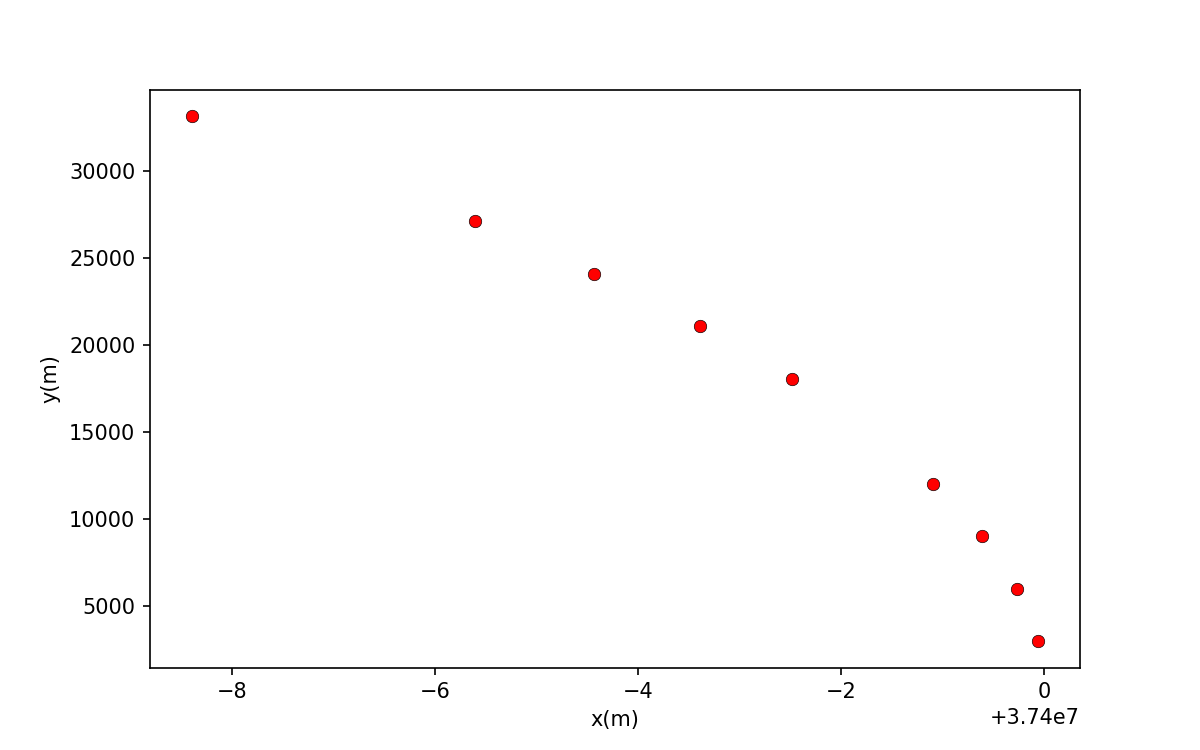

Text(0, 0.5, 'y(m)')

In [36]:
#plotting my orbit
f,ax = plt.subplots(figsize=(8,5))
ax.scatter(xlist,ylist, c='red', linewidths=0.3, edgecolors='k')
ax.set_xlabel("x(m)")
ax.set_ylabel("y(m)")
#ax.set_aspect('equal') #command for to check if it looks right / equal aspect ratio
#ax.set_xlim(-3*(10**8),5*(10**7))
#ax.set_ylim(-3*(10**8),5*(10**8))

In [66]:
#f,ax = plt.subplots(figsize=(8,5))
#ax.plot(tlist,plist)

In [93]:
# thoughts that im too tired to do now
# he said that evenly spaced phi values are important
# so, make a linspace from psilow to psihigh, with steps values (?)
# (or do i need to use whatever the actual code spits back as psirt?)
# pretty sure thats right, since it's not like we'd have more values than npts
# for each value in that, so in range of steps
# calculate the mean anomaly and from that, calculate t
# rather than working on incrementing t each time by dt to get the current time?
# see, thats the question. if i'm getting current time from psi directly then why would i need dt at all?
# though i guess this is a different plot...

ph = 1000
pl = 0
plins = np.linspace(ph,pl,step) #does he mean this or should i calculate psi somewhere
for value in plins:
    index = np.where(plins == value)
    # how can i calculate time, when i need mean anomaly for that, when i need time to get mean anomaly?